# Final Project - Food Freshness Classification Model


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Train: /Users/ryancurling/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train
Test : /Users/ryancurling/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Test

Extracting SAMPLE features (Train)...


Extracting features from Train: 100%|████████| 600/600 [00:15<00:00, 39.38img/s]



Extracting SAMPLE features (Test)...


Extracting features from Test: 100%|█████████| 200/200 [00:04<00:00, 40.63img/s]



Shapes -> Train: (600, 69)  Test: (162, 69)
# Produce classes (train): 9 ['oranges', 'banana', 'apples', 'potato', 'okra', 'tomato', 'capsicum', 'cucumber', 'bittergroud'] ...

Training models...

Test Freshness Accuracy: 0.8272
Test Name Accuracy:      0.7963


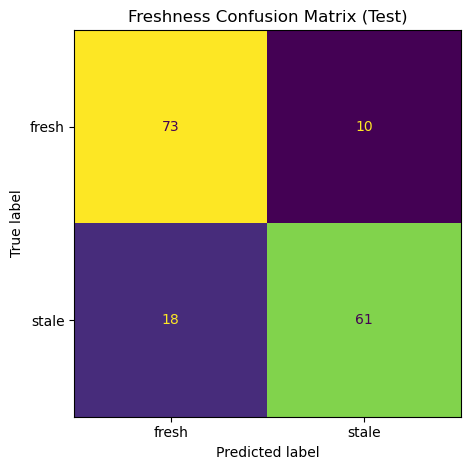


Produce-name classification report (present classes only):

              precision    recall  f1-score   support

     oranges      0.933     0.737     0.824        19
      banana      0.939     0.902     0.920        51
      apples      0.804     0.953     0.872        43
        okra      0.650     0.542     0.591        24
    cucumber      0.652     0.600     0.625        25

   micro avg      0.816     0.796     0.806       162
   macro avg      0.796     0.747     0.766       162
weighted avg      0.815     0.796     0.802       162



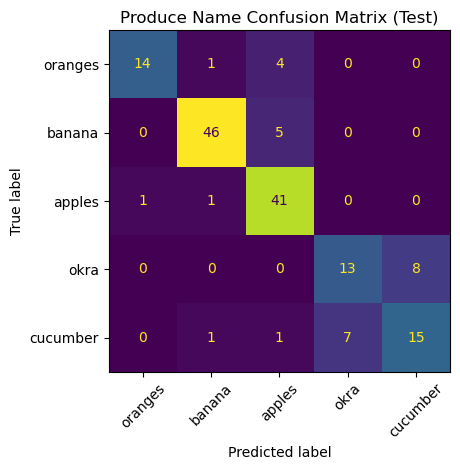


Artifacts saved to: /Users/ryancurling/ML Applications/Final Project/artifacts_classical_sampled
 - Freshness CM: artifacts_classical_sampled/cm_fresh_test.png
 - Name CM     : artifacts_classical_sampled/cm_name_test.png
 - Models      : freshness_model.joblib, name_model.joblib
 - Meta        : meta.json; Feature arrays: X_tr.npy, X_te.npy


In [7]:
# ============================================================
# Food Freshness Project — Fast, Stable (No TensorFlow)
# Multi-task: (1) Fresh vs Stale  (2) Produce Name
# Classical CV features + scikit-learn, with DATA SAMPLING
# ============================================================

# ---------- 0) Imports & lightweight installers ----------
import sys, subprocess, os, re, json, random, pathlib, warnings
import numpy as np

def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].split(">=")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ["kagglehub", "scikit-image", "scikit-learn", "tqdm", "joblib", "matplotlib"]:
    pip_install(pkg)

import kagglehub
from tqdm import tqdm
from skimage import io, color, transform, filters, feature, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings(
    "ignore",
    message="Applying `local_binary_pattern` to floating-point images"
)

# ---------- 1) Config ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Sampling sizes (adjust for speed vs accuracy)
SAMPLE_TRAIN = 600    # e.g., 300–800 on laptops; raise if you want
SAMPLE_TEST  = 200

IMG_SIZE = 256        # resize side for features
ART_DIR = pathlib.Path("artifacts_classical_sampled"); ART_DIR.mkdir(exist_ok=True)

# Freshness keywords (edit if class names differ)
FRESH_WORDS = {"fresh"}
STALE_WORDS = {"stale","rotten","spoiled","bad","old"}
IMG_EXTS = (".jpg",".jpeg",".png",".bmp",".gif",".webp")

# ---------- 2) Download dataset & locate Train/Test ----------
print("Downloading dataset (cached if already present)...")
base_dir = pathlib.Path(kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification"))

def find_dir(root, name):
    cands = sorted(root.rglob(name), key=lambda p: len(str(p)))
    if not cands:
        raise FileNotFoundError(f"Could not find '{name}' under {root}")
    return cands[0]

TRAIN_DIR = find_dir(base_dir, "Train")
TEST_DIR  = find_dir(base_dir, "Test")
print("Train:", TRAIN_DIR)
print("Test :", TEST_DIR)

# ---------- 3) Label helpers ----------
def infer_freshness_from_name(s: str) -> int:
    s = s.lower()
    if any(w in s for w in STALE_WORDS): return 1
    if any(w in s for w in FRESH_WORDS): return 0
    raise ValueError(f"Cannot infer freshness from: {s}")

def infer_produce_name(class_folder: str) -> str:
    s = class_folder.lower()
    for w in (FRESH_WORDS | STALE_WORDS): s = re.sub(w, "", s)
    s = re.sub(r"[^a-z]+"," ",s).strip()
    return s or "unknown"

def iter_images(root: pathlib.Path):
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        prod = infer_produce_name(cls_dir.name)
        fresh = infer_freshness_from_name(cls_dir.name)
        for fp in sorted(cls_dir.rglob("*")):
            if fp.suffix.lower() in IMG_EXTS:
                yield str(fp), fresh, prod

# ---------- 4) Feature extraction ----------
def safe_read(path):
    try:
        img = io.imread(path)
        if img.ndim == 2:                      # grayscale -> RGB
            img = np.stack([img]*3, axis=-1)
        elif img.shape[2] == 4:                # RGBA -> RGB
            img = img[..., :3]
        return img
    except Exception:
        return None

def image_features(path):
    img = safe_read(path)
    if img is None:
        return None
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE), mode="reflect", anti_aliasing=True)
    img = np.clip(img, 0, 1)

    feats = []

    # HSV histograms (16 bins per channel)
    hsv = color.rgb2hsv(img)
    for i in range(3):
        hist, _ = np.histogram(hsv[..., i], bins=16, range=(0,1), density=True)
        feats.extend(hist.tolist())

    # Brightness (mean, std) on V
    V = hsv[..., 2]
    feats += [float(np.mean(V)), float(np.std(V))]

    # Edges (Sobel) stats on grayscale
    gray = color.rgb2gray(img)
    edges = filters.sobel(gray)
    feats += [float(np.mean(edges)), float(np.std(edges))]

    # Sharpness proxy (Laplacian variance)
    lap = filters.laplace(gray)
    feats += [float(np.var(lap))]

    # Local Binary Pattern (uniform, P=8, R=1) → 10 bins (0..9)
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method="uniform")
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)
    feats.extend(hist_lbp.tolist())

    # GLCM texture (levels=32, distances 1–3, 4 angles) → 6 props averaged
    gray_q = exposure.rescale_intensity(gray, out_range=(0, 31)).astype(np.uint8)
    glcm = feature.graycomatrix(
        gray_q, distances=[1,2,3],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=32, symmetric=True, normed=True
    )
    for prop in ("contrast","dissimilarity","homogeneity","ASM","energy","correlation"):
        feats.append(float(feature.graycoprops(glcm, prop).mean()))

    return np.array(feats, dtype=np.float32)   # ~69 dims

def build_xy_sampled(root: pathlib.Path, sample_size=None):
    items = list(iter_images(root))
    if sample_size and len(items) > sample_size:
        random.seed(SEED)
        items = random.sample(items, sample_size)

    name_list, X, y_f, y_n = [], [], [], []

    for path, fresh, prod in tqdm(items, desc=f"Extracting features from {root.name}", unit="img"):
        f = image_features(path)
        if f is None:
            continue
        X.append(f); y_f.append(fresh)
        if prod not in name_list: name_list.append(prod)
        y_n.append(name_list.index(prod))

    return np.array(X), np.array(y_f), np.array(y_n), name_list

# ---------- 5) Build sampled datasets ----------
print("\nExtracting SAMPLE features (Train)...")
X_tr, ytr_f, ytr_n, names_tr = build_xy_sampled(TRAIN_DIR, sample_size=SAMPLE_TRAIN)

print("\nExtracting SAMPLE features (Test)...")
X_te, yte_f, yte_n, names_te = build_xy_sampled(TEST_DIR,  sample_size=SAMPLE_TEST)

# Reconcile name label spaces across Train/Test (map test names into train's ordering)
name_to_idx = {n:i for i,n in enumerate(names_tr)}
keep = []
mapped_yte_n = []
for i, n_id in enumerate(yte_n):
    name = names_te[n_id]
    if name in name_to_idx:
        keep.append(i)
        mapped_yte_n.append(name_to_idx[name])

X_te = X_te[keep]
yte_f = yte_f[keep]
yte_n = np.array(mapped_yte_n, dtype=int)

print("\nShapes -> Train:", X_tr.shape, " Test:", X_te.shape)
print("# Produce classes (train):", len(names_tr), names_tr[:10], "...")
assert len(names_tr) >= 2, "Need at least two produce-name classes."

# ---------- 6) Train models ----------
fresh_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=1))
])
name_clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=1))
])

print("\nTraining models...")
fresh_clf.fit(X_tr, ytr_f)
name_clf.fit(X_tr, ytr_n)

# ---------- 7) Evaluate ----------
pred_fresh = fresh_clf.predict(X_te)
pred_name  = name_clf.predict(X_te)

fresh_acc = float((pred_fresh == yte_f).mean())
name_acc  = float((pred_name  == yte_n).mean())

print(f"\nTest Freshness Accuracy: {fresh_acc:.4f}")
print(f"Test Name Accuracy:      {name_acc:.4f}")

# Freshness confusion matrix
cm_fresh = confusion_matrix(yte_f, pred_fresh, labels=[0,1])
disp = ConfusionMatrixDisplay(cm_fresh, display_labels=["fresh","stale"])
fig = disp.plot(colorbar=False).figure_
plt.title("Freshness Confusion Matrix (Test)")
plt.tight_layout()
cm_fresh_path = ART_DIR / "cm_fresh_test.png"
fig.savefig(cm_fresh_path, dpi=150)
plt.show()

# Name classification report + confusion matrix (robust to missing classes)
labels_present = np.unique(yte_n)
present_names = [names_tr[i] for i in labels_present]

report = classification_report(
    yte_n, pred_name,
    labels=labels_present,
    target_names=present_names,
    zero_division=0,
    digits=3
)
print("\nProduce-name classification report (present classes only):\n")
print(report)

cm_names = confusion_matrix(yte_n, pred_name, labels=labels_present)
disp2 = ConfusionMatrixDisplay(cm_names, display_labels=present_names)
fig2 = disp2.plot(colorbar=False, xticks_rotation=45).figure_
plt.title("Produce Name Confusion Matrix (Test)")
plt.tight_layout()
cm_names_path = ART_DIR / "cm_name_test.png"
fig2.savefig(cm_names_path, dpi=150)
plt.show()

# ---------- 8) Save artifacts ----------
from joblib import dump
dump(fresh_clf, ART_DIR / "freshness_model.joblib")
dump(name_clf,  ART_DIR / "name_model.joblib")
np.save(ART_DIR / "X_tr.npy", X_tr); np.save(ART_DIR / "X_te.npy", X_te)
with open(ART_DIR / "meta.json","w") as f:
    json.dump({
        "fresh_test_accuracy": fresh_acc,
        "name_test_accuracy": name_acc,
        "produce_names_train": names_tr,
        "sample_train": SAMPLE_TRAIN,
        "sample_test": SAMPLE_TEST
    }, f, indent=2)

print("\nArtifacts saved to:", ART_DIR.resolve())
print(" - Freshness CM:", cm_fresh_path)
print(" - Name CM     :", cm_names_path)
print(" - Models      : freshness_model.joblib, name_model.joblib")
print(" - Meta        : meta.json; Feature arrays: X_tr.npy, X_te.npy")


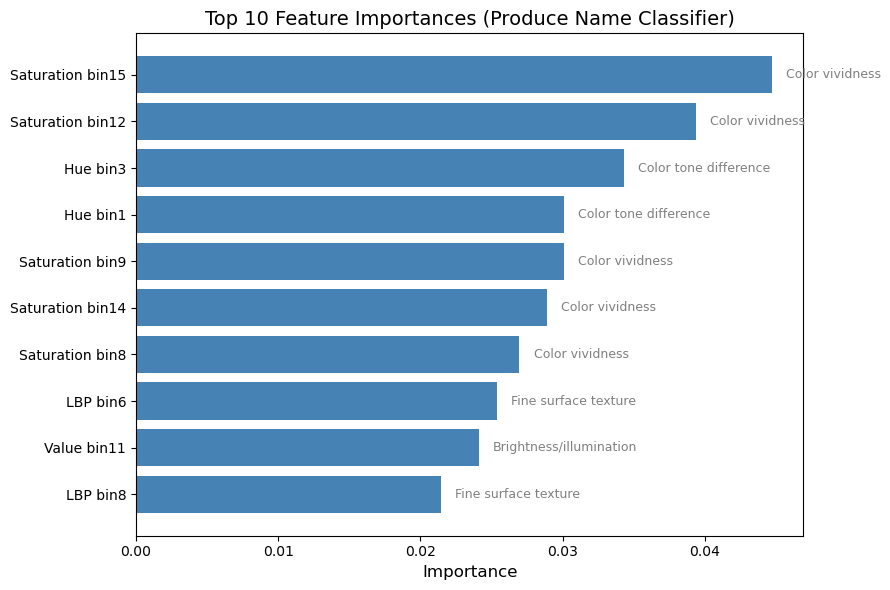

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =====================================================
# 1. Create human-readable feature names
# =====================================================

feature_names = []

# HSV color histograms (16 bins per channel × 3 channels = 48 features)
for ch, cname in enumerate(["Hue", "Saturation", "Value"]):
    for b in range(16):
        feature_names.append(f"{cname} bin{b}")

# Brightness statistics (2 features)
feature_names += ["Value mean", "Value std"]

# Edge and sharpness statistics (3 features)
feature_names += ["Sobel mean", "Sobel std", "Laplacian variance"]

# Local Binary Pattern (LBP) histogram (10 features)
for i in range(10):
    feature_names.append(f"LBP bin{i}")

# Gray-Level Co-occurrence Matrix (GLCM) texture features (6 features)
feature_names += [
    "GLCM contrast", "GLCM dissimilarity", "GLCM homogeneity",
    "GLCM ASM", "GLCM energy", "GLCM correlation"
]

assert len(feature_names) == 69, f"Expected 69 features, got {len(feature_names)}"

# =====================================================
# 2. Extract feature importances
# =====================================================

importances = name_clf.named_steps['rf'].feature_importances_
feat_idx = np.argsort(importances)[::-1][:10]

# =====================================================
# 3. Plot with meaningful labels and annotations
# =====================================================

plt.figure(figsize=(9,6))
bars = plt.barh(range(len(feat_idx)), importances[feat_idx][::-1], color="steelblue")

# Replace "Feature X" with actual descriptive names
yticklabels = [feature_names[i] for i in feat_idx[::-1]]
plt.yticks(range(len(feat_idx)), yticklabels, fontsize=10)
plt.xlabel("Importance", fontsize=12)
plt.title("Top 10 Feature Importances (Produce Name Classifier)", fontsize=14)

# Add short, human-readable annotations to each bar (for slides)
explanations = {
    "Hue": "Color tone difference",
    "Saturation": "Color vividness",
    "Value": "Brightness/illumination",
    "Sobel": "Edge/texture detail",
    "Laplacian": "Sharpness/focus",
    "LBP": "Fine surface texture",
    "GLCM": "Coarse texture pattern"
}

for bar, label in zip(bars, yticklabels):
    meaning = next((v for k, v in explanations.items() if k in label), "")
    plt.text(
        bar.get_width() + 0.001,
        bar.get_y() + bar.get_height()/2,
        meaning,
        va="center",
        fontsize=9,
        color="gray"
    )

plt.tight_layout()
plt.show()


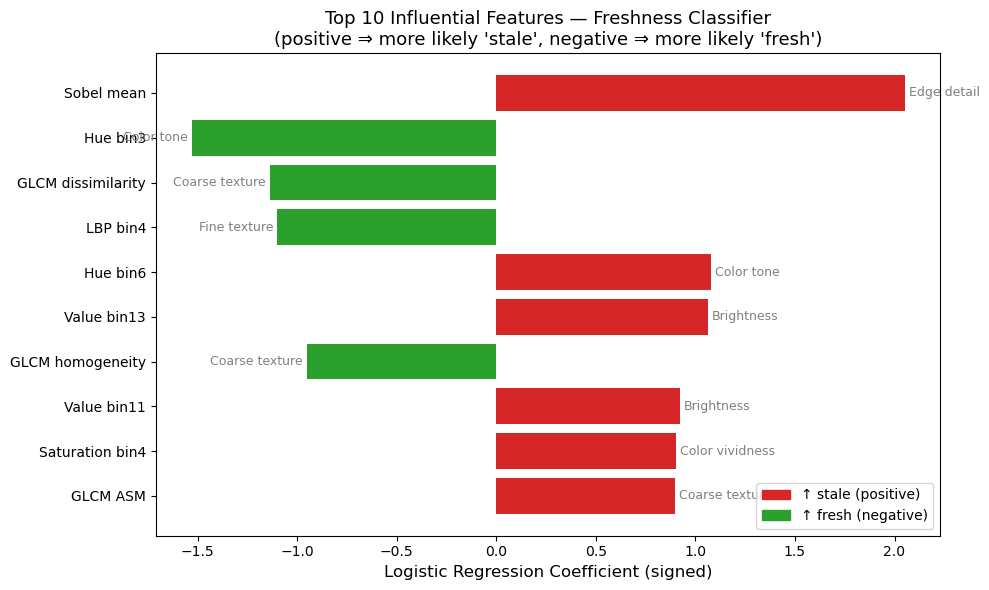

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------
# 0) Reuse or build human-readable names
# ------------------------------------------
if "feature_names" not in globals():
    feature_names = []
    # HSV histograms (48)
    for cname in ["Hue", "Saturation", "Value"]:
        for b in range(16):
            feature_names.append(f"{cname} bin{b}")
    # Brightness stats (2)
    feature_names += ["Value mean", "Value std"]
    # Edges & sharpness (3)
    feature_names += ["Sobel mean", "Sobel std", "Laplacian variance"]
    # LBP (10)
    for i in range(10):
        feature_names.append(f"LBP bin{i}")
    # GLCM (6)
    feature_names += [
        "GLCM contrast", "GLCM dissimilarity", "GLCM homogeneity",
        "GLCM ASM", "GLCM energy", "GLCM correlation"
    ]
    assert len(feature_names) == 69, f"Expected 69 features, got {len(feature_names)}"

# ------------------------------------------
# 1) Get signed coefficients from pipeline
#    fresh_clf = Pipeline([("scaler", ...), ("lr", LogisticRegression(...))])
# ------------------------------------------
coef = fresh_clf.named_steps["lr"].coef_.ravel()   # shape: (n_features,)
abs_coef = np.abs(coef)

# Top-k by absolute magnitude
k = 10
top_idx = np.argsort(abs_coef)[-k:][::-1]

# ------------------------------------------
# 2) Plot (signed bars). Color encodes direction:
#    red = pushes to stale (positive); green = pushes to fresh (negative)
# ------------------------------------------
colors = ["#d62728" if coef[i] > 0 else "#2ca02c" for i in top_idx]  # red stale, green fresh

plt.figure(figsize=(10,6))
bars = plt.barh(range(k), coef[top_idx][::-1], color=[colors[::-1][i] for i in range(k)])
yt = [feature_names[i] for i in top_idx[::-1]]
plt.yticks(range(k), yt, fontsize=10)
plt.xlabel("Logistic Regression Coefficient (signed)", fontsize=12)
plt.title("Top 10 Influential Features — Freshness Classifier\n(positive ⇒ more likely 'stale', negative ⇒ more likely 'fresh')", fontsize=13)

# Simple legend
import matplotlib.patches as mpatches
patch_stale = mpatches.Patch(color="#d62728", label="↑ stale (positive)")
patch_fresh = mpatches.Patch(color="#2ca02c", label="↑ fresh (negative)")
plt.legend(handles=[patch_stale, patch_fresh], loc="lower right")

# Short explanations (optional)
explanations = {
    "Hue": "Color tone",
    "Saturation": "Color vividness",
    "Value": "Brightness",
    "Sobel": "Edge detail",
    "Laplacian": "Sharpness/focus",
    "LBP": "Fine texture",
    "GLCM": "Coarse texture"
}
for y, idx in enumerate(top_idx[::-1]):
    label = feature_names[idx]
    meaning = next((v for k, v in explanations.items() if k in label), "")
    if meaning:
        x = coef[idx]
        plt.text(x + (0.02 if x >= 0 else -0.02), y, meaning,
                 va="center", ha="left" if x >= 0 else "right", color="gray", fontsize=9)

plt.tight_layout()
plt.show()


In [13]:
import random, pandas as pd

MAX_TEST_IMAGES_FOR_VIS = 200  # adjust if you want more/less

def collect_test_predictions(test_root, max_images=200):
    # Gather (path, true_fresh(0/1), true_name_idx)
    items = []
    for cls_dir in sorted([p for p in TEST_DIR.iterdir() if p.is_dir()]):
        prod = infer_produce_name(cls_dir.name)
        fresh = infer_freshness_from_name(cls_dir.name)
        for fp in sorted(cls_dir.rglob("*")):
            if fp.suffix.lower() in IMG_EXTS:
                items.append((str(fp), fresh, prod))

    random.seed(SEED)
    if len(items) > max_images:
        items = random.sample(items, max_images)

    rows = []
    for path, fresh, prod in items:
        # map produce name to the index space of the *train* name model
        if prod not in name_to_idx:
            continue
        name_idx = name_to_idx[prod]

        feats = image_features(path)
        if feats is None: 
            continue

        pf = int(fresh_clf.predict(feats.reshape(1, -1))[0])
        pn = int(name_clf.predict(feats.reshape(1, -1))[0])

        rows.append({
            "path": path,
            "true_fresh": fresh,
            "pred_fresh": pf,
            "fresh_correct": int(pf == fresh),
            "true_name_idx": name_idx,
            "pred_name_idx": pn,
            "true_name": names_tr[name_idx],
            "pred_name": names_tr[pn] if pn < len(names_tr) else f"idx{pn}"
        })
    return pd.DataFrame(rows)

df_pred = collect_test_predictions(TEST_DIR, max_images=MAX_TEST_IMAGES_FOR_VIS)
print(df_pred.head())
print("Rows collected:", len(df_pred))


                                                path  true_fresh  pred_fresh  \
0  /Users/ryancurling/.cache/kagglehub/datasets/s...           1           1   
1  /Users/ryancurling/.cache/kagglehub/datasets/s...           0           0   
2  /Users/ryancurling/.cache/kagglehub/datasets/s...           0           0   
3  /Users/ryancurling/.cache/kagglehub/datasets/s...           0           0   
4  /Users/ryancurling/.cache/kagglehub/datasets/s...           0           1   

   fresh_correct  true_name_idx  pred_name_idx true_name pred_name  
0              1              7              4  cucumber      okra  
1              1              1              1    banana    banana  
2              1              2              2    apples    apples  
3              1              4              4      okra      okra  
4              0              4              7      okra  cucumber  
Rows collected: 162


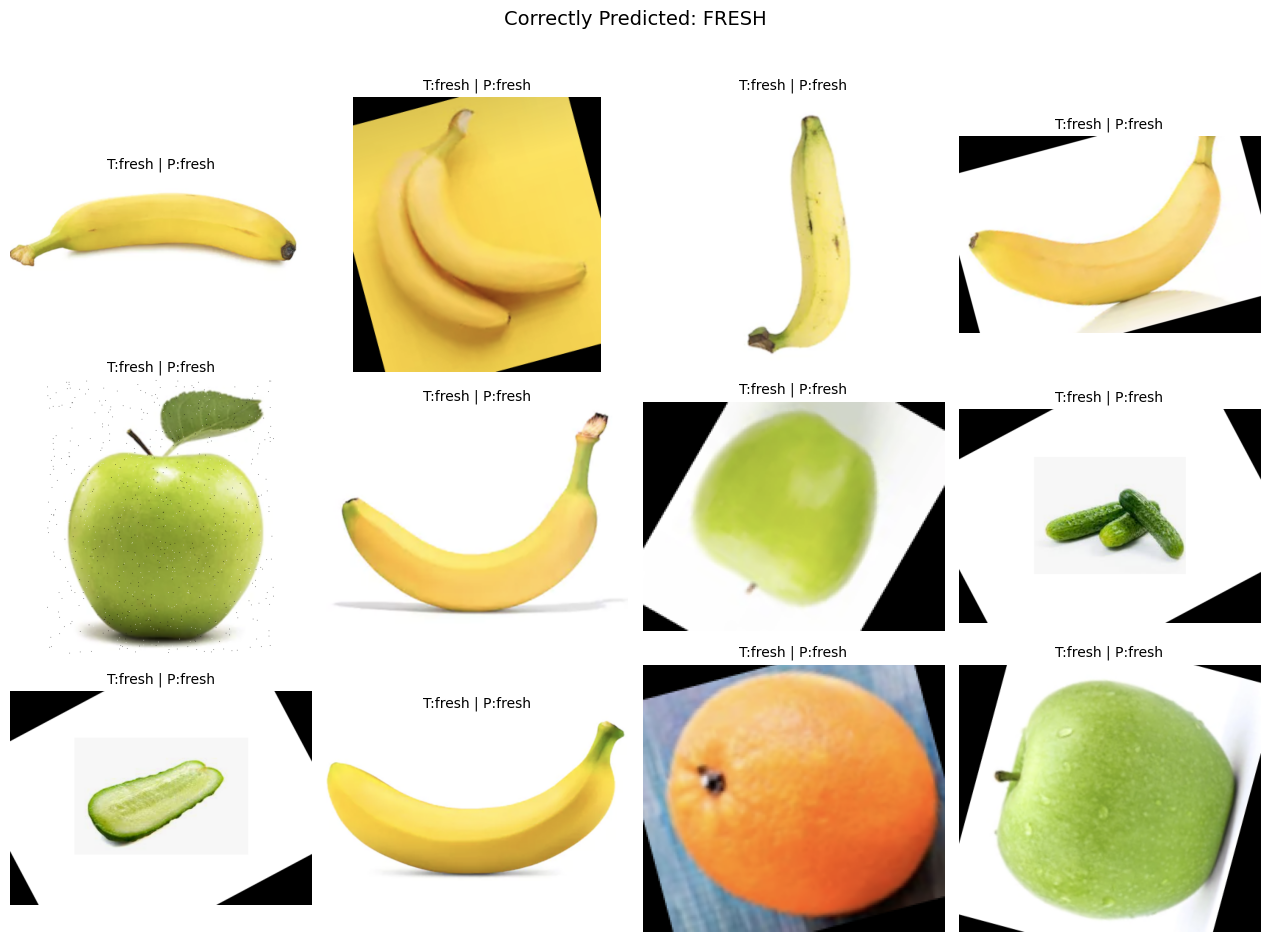

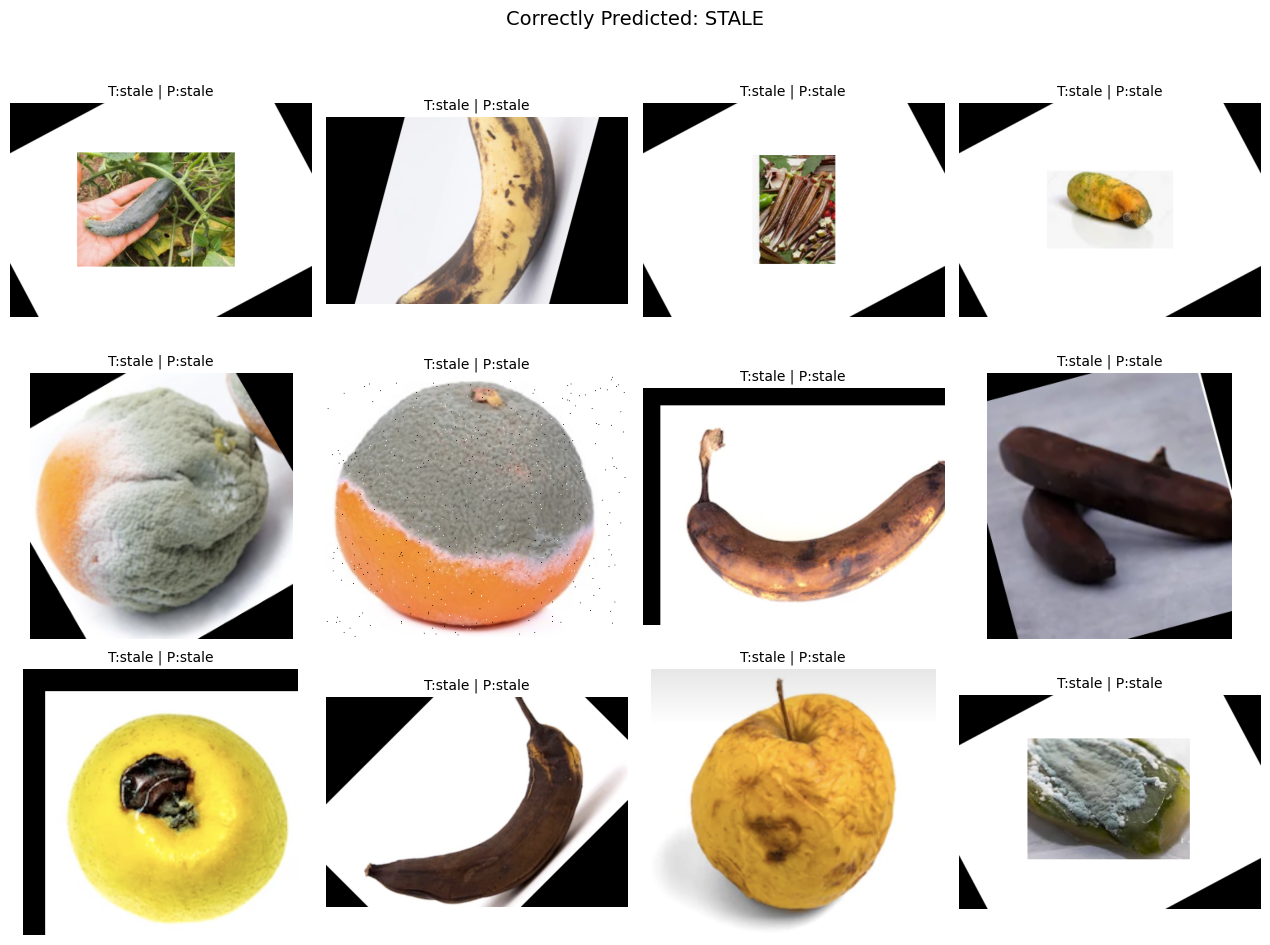

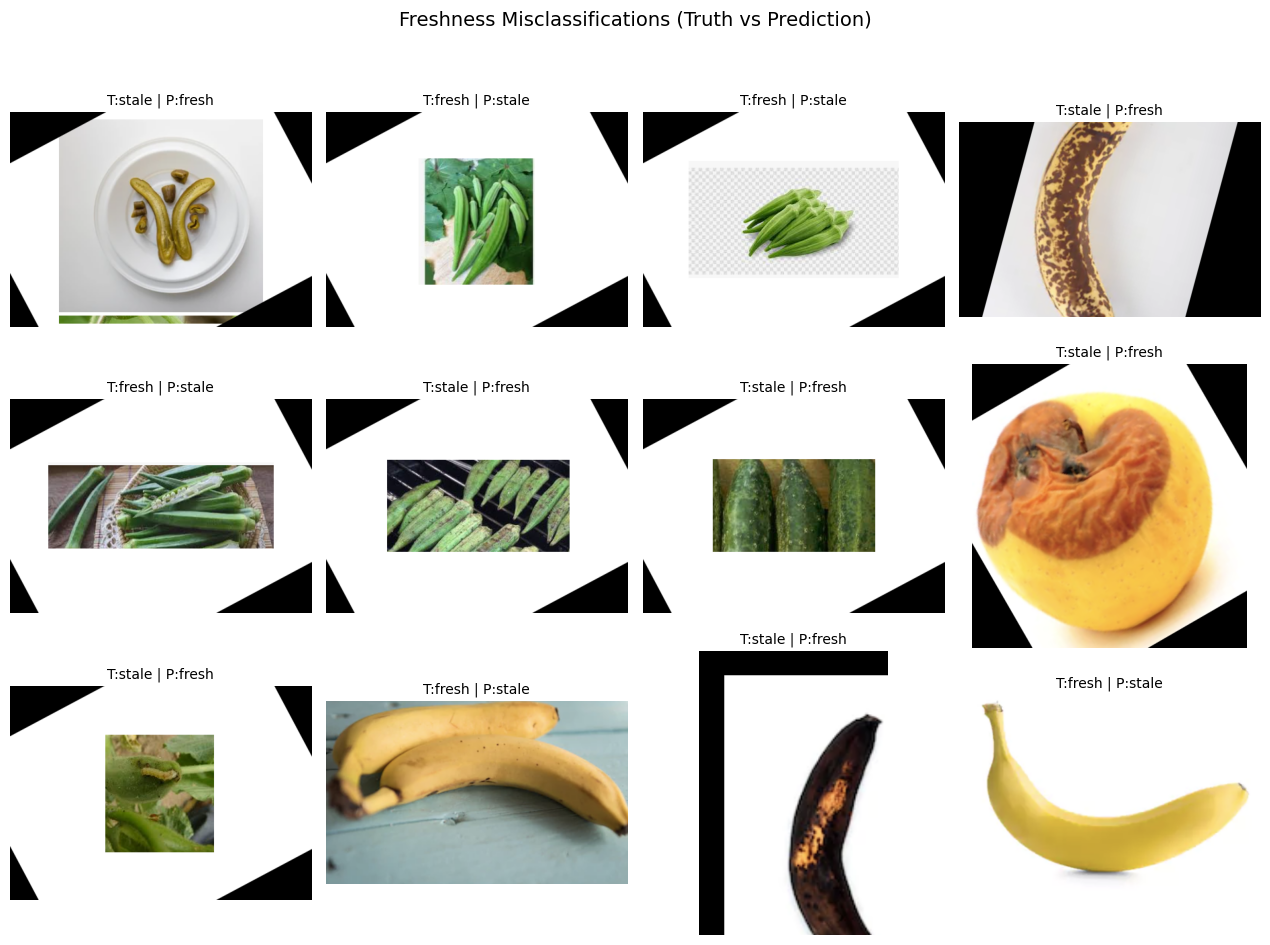

In [15]:
import math
import matplotlib.pyplot as plt
from skimage import io

def show_grid(df, title, out_path, n=12, by="fresh_correct", select_value=1, filter_col=None, filter_value=None):
    use = df.copy()
    if filter_col is not None:
        use = use[use[filter_col] == filter_value]
    use = use[use[by] == select_value]
    use = use.sample(min(n, len(use)), random_state=SEED)

    cols = 4
    rows = math.ceil(len(use) / cols)
    plt.figure(figsize=(cols*3.2, rows*3.2))
    for i, (_, r) in enumerate(use.iterrows()):
        plt.subplot(rows, cols, i+1)
        img = io.imread(r["path"])
        plt.imshow(img)
        plt.axis("off")
        ttl = f"T:{'fresh' if r['true_fresh']==0 else 'stale'} | P:{'fresh' if r['pred_fresh']==0 else 'stale'}"
        plt.title(ttl, fontsize=10)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig(out_path, dpi=150)
    plt.show()

# 3A) Correctly predicted FRESH
show_grid(
    df_pred,
    title="Correctly Predicted: FRESH",
    out_path=ART_DIR / "grid_correct_fresh.png",
    n=12,
    by="fresh_correct",
    select_value=1,
    filter_col="true_fresh",
    filter_value=0
)

# 3B) Correctly predicted STALE
show_grid(
    df_pred,
    title="Correctly Predicted: STALE",
    out_path=ART_DIR / "grid_correct_stale.png",
    n=12,
    by="fresh_correct",
    select_value=1,
    filter_col="true_fresh",
    filter_value=1
)

# 3C) Freshness mistakes (great for “limitations” slide)
show_grid(
    df_pred,
    title="Freshness Misclassifications (Truth vs Prediction)",
    out_path=ART_DIR / "grid_fresh_errors.png",
    n=12,
    by="fresh_correct",
    select_value=0
)


### Grid of name classifcations

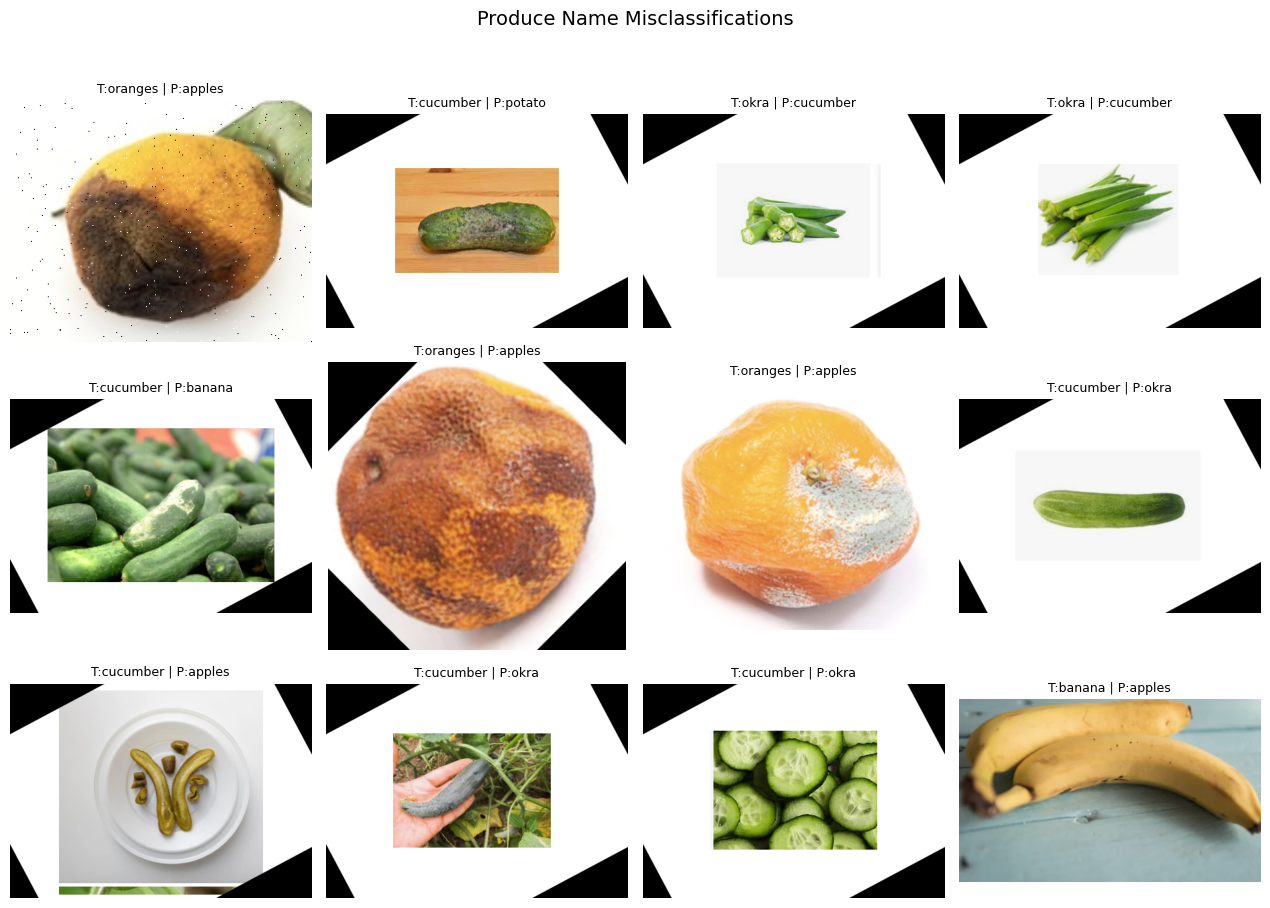

In [18]:
def show_name_errors(df, out_path, n=12):
    wrong = df[df["pred_name_idx"] != df["true_name_idx"]]
    wrong = wrong.sample(min(n, len(wrong)), random_state=SEED)

    cols = 4
    rows = math.ceil(len(wrong) / cols)
    plt.figure(figsize=(cols*3.2, rows*3.2))
    for i, (_, r) in enumerate(wrong.iterrows()):
        plt.subplot(rows, cols, i+1)
        img = io.imread(r["path"])
        plt.imshow(img); plt.axis("off")
        plt.title(f"T:{r['true_name']} | P:{r['pred_name']}", fontsize=9)
    plt.suptitle("Produce Name Misclassifications", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.savefig(out_path, dpi=150)
    plt.show()

show_name_errors(df_pred, ART_DIR / "grid_name_errors.png", n=12)


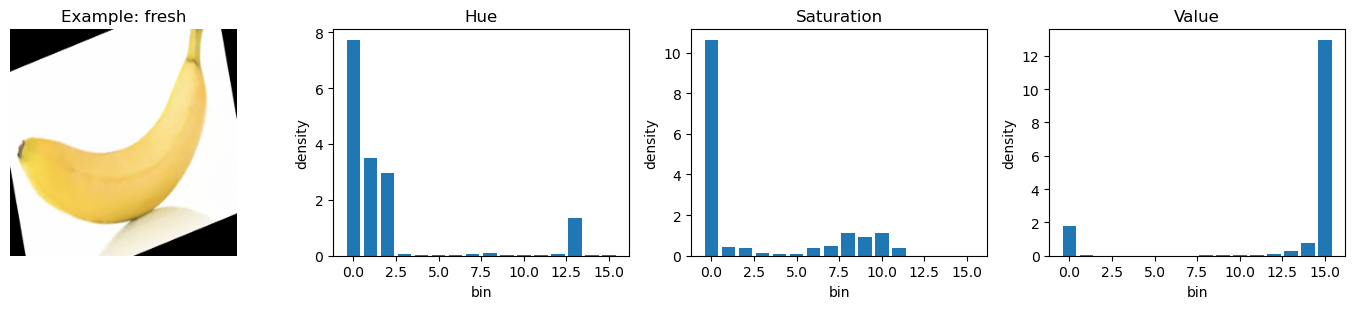

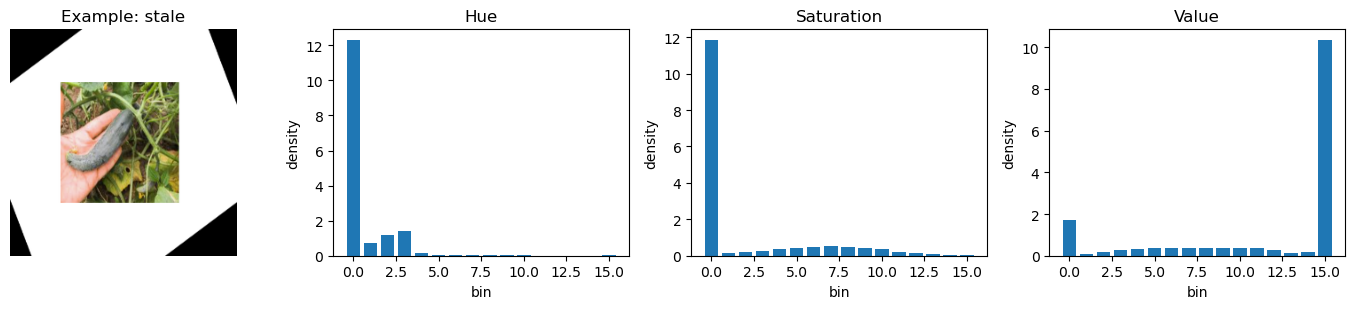

In [20]:
from skimage import color, transform
import numpy as np
import matplotlib.pyplot as plt

def hsv_histogram_panels(path, label, bins=16):
    img = io.imread(path)
    if img.ndim == 2: img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 4: img = img[...,:3]
    img = transform.resize(img, (256,256), anti_aliasing=True)
    hsv = color.rgb2hsv(np.clip(img, 0, 1))

    fig, axes = plt.subplots(1, 4, figsize=(14,3.2))
    axes[0].imshow(img); axes[0].axis("off"); axes[0].set_title(f"Example: {label}")

    names = ["Hue", "Saturation", "Value"]
    for i in range(3):
        h, edges = np.histogram(hsv[..., i], bins=bins, range=(0,1), density=True)
        axes[i+1].bar(np.arange(bins), h)
        axes[i+1].set_title(names[i]); axes[i+1].set_xlabel("bin"); axes[i+1].set_ylabel("density")
    plt.tight_layout()
    return fig

# pick one fresh and one stale from df_pred
fresh_example = df_pred[df_pred["true_fresh"]==0].iloc[0]["path"]
stale_example = df_pred[df_pred["true_fresh"]==1].iloc[0]["path"]

fig1 = hsv_histogram_panels(fresh_example, "fresh")
fig1.savefig(ART_DIR / "hsv_hist_fresh.png", dpi=150); plt.show()

fig2 = hsv_histogram_panels(stale_example, "stale")
fig2.savefig(ART_DIR / "hsv_hist_stale.png", dpi=150); plt.show()


Saved: /Users/ryancurling/ML Applications/Final Project/title_fresh_vs_stale_grid_MULTI.png  | Rows: 3  | Source: test  | Produces: Apple, Potato, Tomato


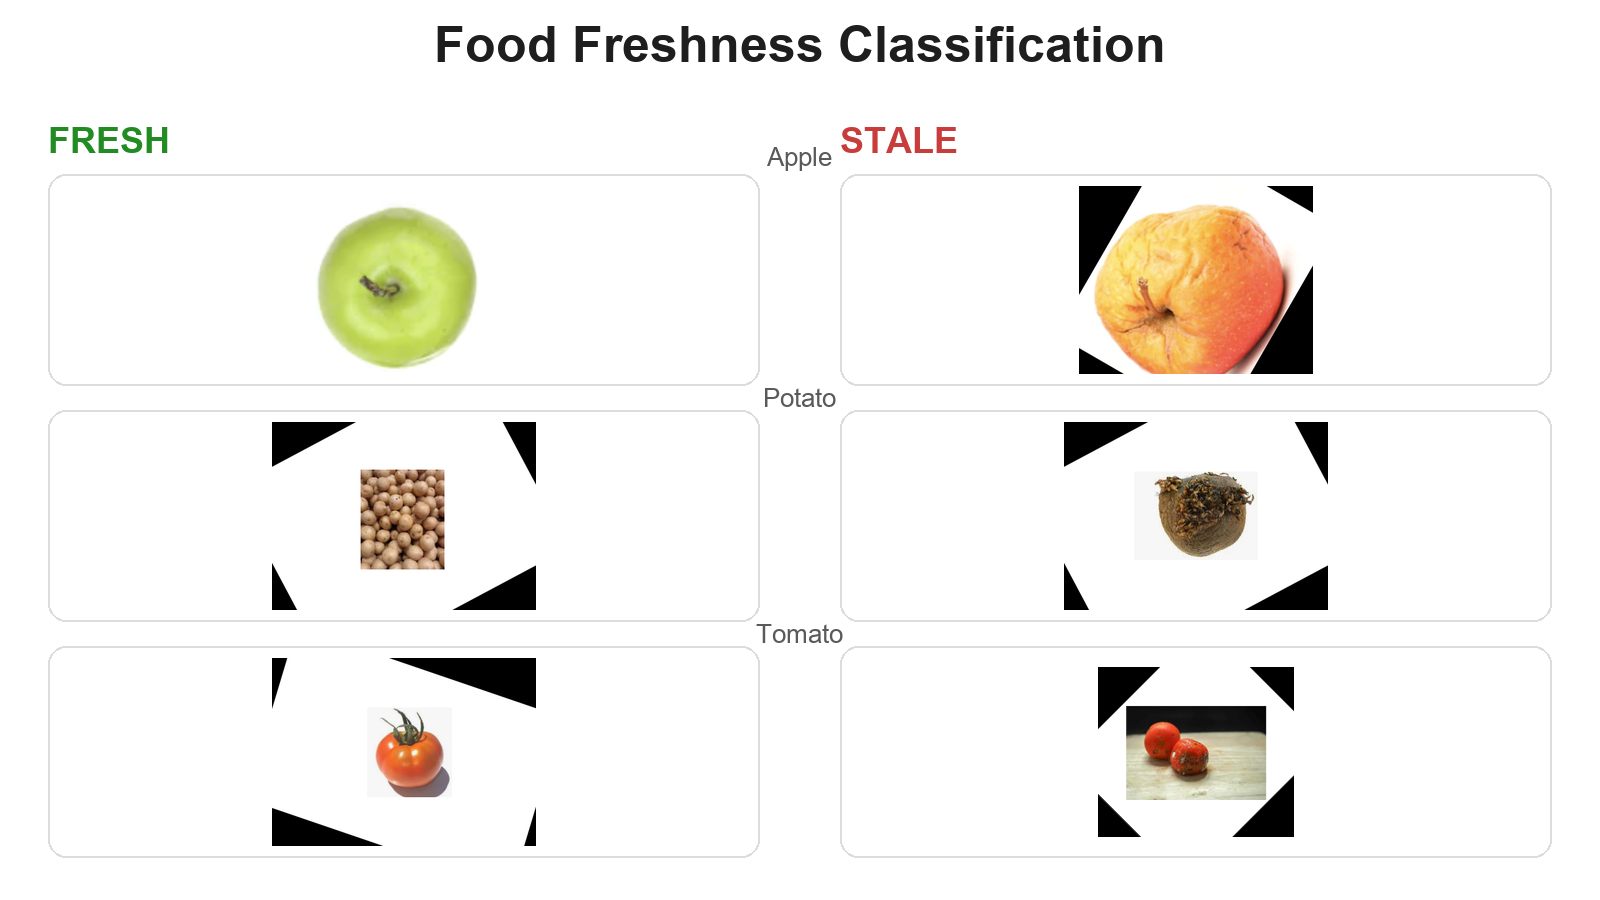

In [50]:
# ============================================================
# Clean multi-produce grid for title slide (FRESH | STALE)
# - Each row is a different produce
# - Corrects spelling/labels (Potato, Apple, Tomato, …)
# - Sorted alphabetically
# - Handles transparent PNGs (no black triangles)
# - Saves & displays a 1600x900 PNG
# ============================================================

import os, re, random, pathlib
from collections import defaultdict
from PIL import Image as PILImage, ImageDraw, ImageFont
from IPython.display import display

# ---------------- Fonts & helpers ----------------
def try_font(size, bold=False):
    candidates = [
        "/System/Library/Fonts/Supplemental/Arial Bold.ttf" if bold else "/System/Library/Fonts/Supplemental/Arial.ttf",
        "Arial Bold.ttf" if bold else "Arial.ttf",
        "arialbd.ttf" if bold else "arial.ttf",
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf" if bold else "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf",
    ]
    for p in candidates:
        try:
            return ImageFont.truetype(p, size)
        except Exception:
            pass
    return ImageFont.load_default()

def text_size(draw, text, font):
    x0, y0, x1, y1 = draw.textbbox((0, 0), text, font=font)
    return (x1 - x0), (y1 - y0)

# ---------------- Dataset paths ----------------
try:
    TEST_DIR, TRAIN_DIR  # reuse if already defined
except NameError:
    import kagglehub
    base_dir = pathlib.Path(kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification"))
    def find_dir(root, name):
        cands = sorted(root.rglob(name), key=lambda p: len(str(p)))
        if not cands: raise FileNotFoundError(f"'{name}' not found under {root}")
        return cands[0]
    TRAIN_DIR = find_dir(base_dir, "Train")
    TEST_DIR  = find_dir(base_dir, "Test")

# ---------------- Label parsing ----------------
FRESH_WORDS = {"fresh"}
STALE_WORDS = {"stale","rotten","spoiled","bad","old"}
IMG_EXTS    = {".jpg",".jpeg",".png",".bmp",".webp",".gif"}

def infer_freshness_from_name(s: str) -> int:
    s = s.lower()
    if any(w in s for w in STALE_WORDS): return 1
    if any(w in s for w in FRESH_WORDS): return 0
    raise ValueError(f"Cannot infer freshness from: {s}")

def infer_produce_name(class_folder: str) -> str:
    s = class_folder.lower()
    for w in (FRESH_WORDS | STALE_WORDS): s = re.sub(w, "", s)
    s = re.sub(r"[^a-z]+"," ",s).strip()
    return s or "unknown"

def list_images(root: pathlib.Path):
    for p in sorted(root.rglob("*")):
        if p.suffix.lower() in IMG_EXTS:
            yield p

# Clean label mapping (fix typos/plurals)
CLEAN_LABELS = {
    "patato": "Potato", "potato": "Potato", "potatos": "Potato", "potatoes": "Potato",
    "apple": "Apple", "apples": "Apple",
    "tomato": "Tomato", "tomatos": "Tomato", "tomatoes": "Tomato", "tamto": "Tomato", "tamato": "Tomato",
    "banana": "Banana", "bananas": "Banana",
    "orange": "Orange", "oranges": "Orange",
    "okra": "Okra",
    "cucumber": "Cucumber", "cucumbers": "Cucumber",
    "capsicum": "Pepper", "pepper": "Pepper", "peppers": "Pepper",
    "carrot": "Carrot", "carrots": "Carrot",
}

def clean_label(raw_name: str) -> str:
    n = raw_name.strip().lower()
    return CLEAN_LABELS.get(n, n.capitalize())

# ---------------- Build catalogs ----------------
def build_catalog(root: pathlib.Path):
    cat = defaultdict(lambda: {"fresh": [], "stale": []})
    for cls in sorted([p for p in root.iterdir() if p.is_dir()]):
        prod = infer_produce_name(cls.name)
        key  = "fresh" if infer_freshness_from_name(cls.name) == 0 else "stale"
        for imgp in list_images(cls):
            cat[prod][key].append(imgp)
    return cat

cat_test  = build_catalog(pathlib.Path(TEST_DIR))
cat_train = build_catalog(pathlib.Path(TRAIN_DIR))

# Candidates = produce types with BOTH fresh & stale
candidates = [k for k,v in cat_test.items()  if v["fresh"] and v["stale"]]
source = "test"
if not candidates:
    candidates = [k for k,v in cat_train.items() if v["fresh"] and v["stale"]]
    source = "train"
assert candidates, "No produce with both fresh and stale images found."

# Choose rows (sorted clean labels)
ROWS = 3  # <— change to 2 if you want fewer rows
random.seed(42)
chosen_raw = random.sample(candidates, min(ROWS, len(candidates)))
chosen = sorted(chosen_raw, key=lambda x: clean_label(x))
catalog = cat_test if source == "test" else cat_train

# ---------------- Canvas & layout ----------------
W, H = 1600, 900
PAD = 48
COL_GAP = 80
ROW_GAP = 24
HEADER_H = 120
LABEL_H = 48

BG = (255,255,255)
TXT = (30,30,30)
GREEN = (34,139,34)
RED = (200,60,60)
BORDER = (220,220,220)

canvas = PILImage.new("RGB", (W, H), BG)
draw = ImageDraw.Draw(canvas)

title_font = try_font(50, bold=True)
tag_font   = try_font(36, bold=True)
prod_font  = try_font(26, bold=False)

# Single title
title = "Food Freshness Classification"
tw, th = text_size(draw, title, title_font)
draw.text(((W - tw)//2, PAD//3), title, fill=TXT, font=title_font)

# Column labels
left_x  = PAD
right_x = W//2 + COL_GAP//2
draw.text((left_x,  HEADER_H), "FRESH", fill=GREEN, font=tag_font)
draw.text((right_x, HEADER_H), "STALE", fill=RED,   font=tag_font)

# Cell sizes
usable_h = H - (HEADER_H + LABEL_H + PAD)
cell_h   = (usable_h - (ROWS-1)*ROW_GAP) // ROWS
cell_w   = (W - 2*PAD - COL_GAP) // 2
img_box_w, img_box_h = cell_w, cell_h

def paste_clean(path, box_w, box_h, bg=BG, border=BORDER, radius=18):
    """Letterbox-fit into box; composite transparent images over white."""
    im = PILImage.open(path)
    if im.mode in ("RGBA", "LA"):
        white = PILImage.new("RGBA", im.size, (255,255,255,255))
        im = PILImage.alpha_composite(white, im.convert("RGBA")).convert("RGB")
    else:
        im = im.convert("RGB")
    im.thumbnail((box_w-24, box_h-24), PILImage.LANCZOS)

    tile = PILImage.new("RGB", (box_w, box_h), bg)
    d = ImageDraw.Draw(tile)
    d.rounded_rectangle([0,0,box_w-1,box_h-1], radius=radius, outline=border, width=2)
    x = (box_w - im.width)//2
    y = (box_h - im.height)//2
    tile.paste(im, (x, y))
    return tile

# ---------------- Render rows ----------------
y0 = HEADER_H + LABEL_H + 6
for prod in chosen:
    label = clean_label(prod)
    lw, lh = text_size(draw, label, prod_font)
    draw.text(((W - lw)//2, y0 - lh - 8), label, fill=(90,90,90), font=prod_font)

    f_list = catalog[prod]["fresh"]
    s_list = catalog[prod]["stale"]
    f_img  = random.choice(f_list)
    s_img  = random.choice(s_list)

    tile_f = paste_clean(f_img, img_box_w, img_box_h)
    tile_s = paste_clean(s_img, img_box_w, img_box_h)
    canvas.paste(tile_f, (left_x,  y0))
    canvas.paste(tile_s, (right_x, y0))

    y0 += img_box_h + ROW_GAP

# ---------------- Save & display ----------------
out_path = "title_fresh_vs_stale_grid_MULTI.png"
canvas.save(out_path, "PNG")
print(f"Saved: {os.path.abspath(out_path)}  | Rows: {len(chosen)}  | Source: {source}  | Produces: {', '.join([clean_label(c) for c in chosen])}")
display(canvas)


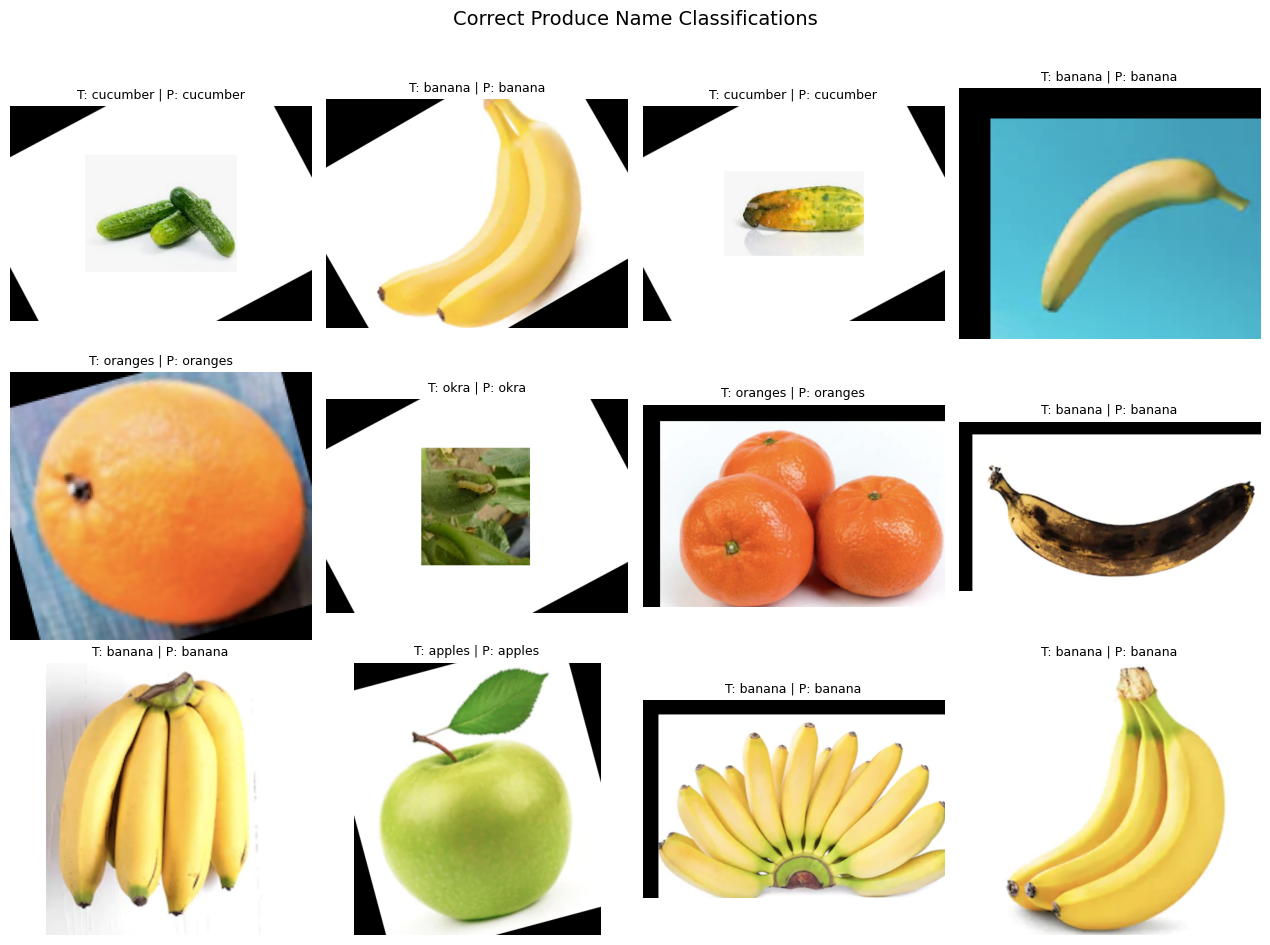

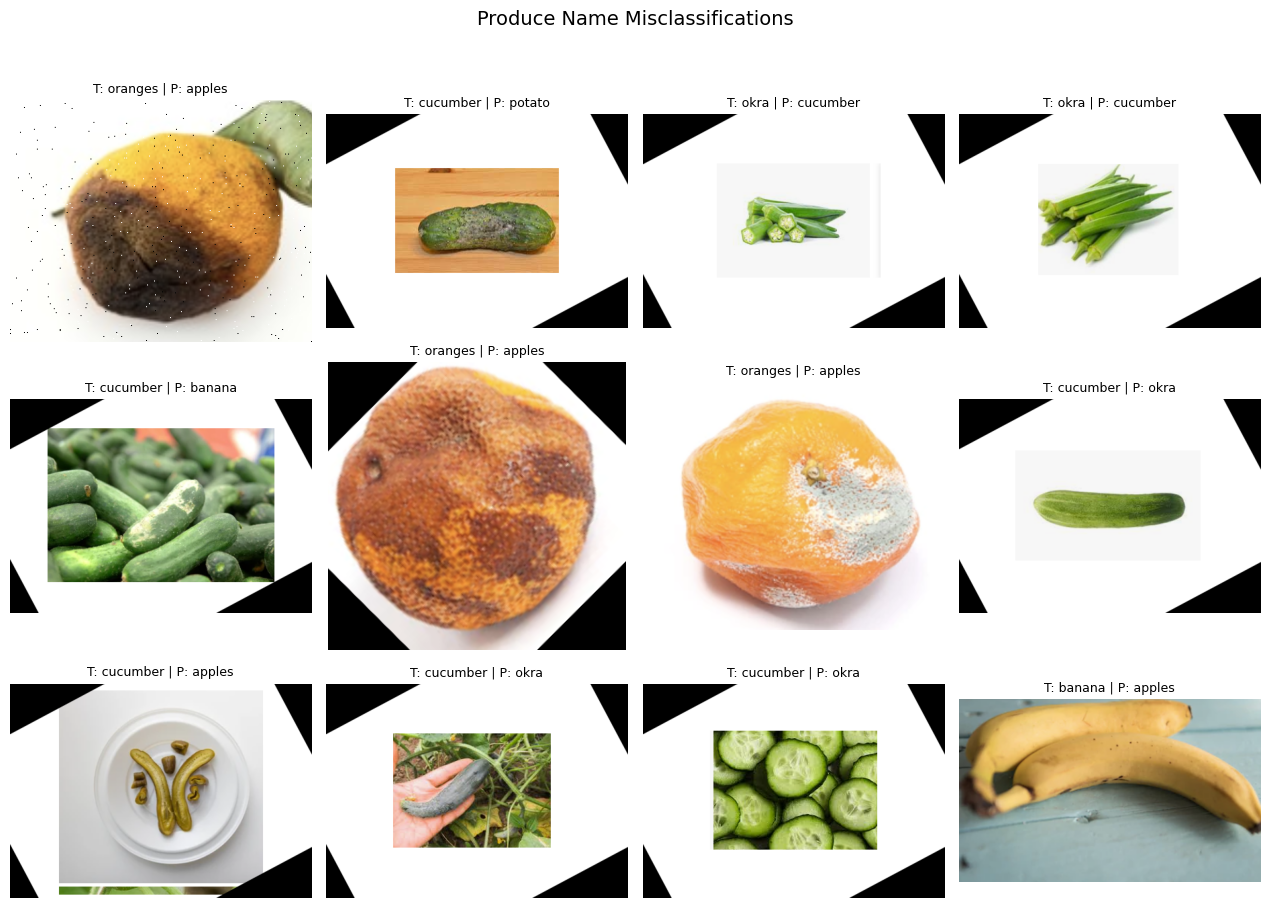

In [52]:
# -------------------------------------------------------
# Visualize sample predictions for produce name classification
# -------------------------------------------------------

import matplotlib.pyplot as plt
import math, random
from skimage import io

SEED = 42
random.seed(SEED)

def show_name_predictions(df, out_path, n=12, correct=True):
    """
    Display sample images for correct or incorrect produce name predictions.

    Parameters:
        df : DataFrame containing columns:
            - 'path' (image file path)
            - 'true_name' (true label)
            - 'pred_name' (predicted label)
            - 'true_name_idx', 'pred_name_idx'
        out_path : Path to save output figure
        n : Number of images to display (default 12)
        correct : If True, show correct predictions; else show misclassifications
    """
    # Filter depending on whether correct or incorrect predictions are shown
    if correct:
        subset = df[df["pred_name_idx"] == df["true_name_idx"]]
        title = "Correct Produce Name Classifications"
    else:
        subset = df[df["pred_name_idx"] != df["true_name_idx"]]
        title = "Produce Name Misclassifications"

    subset = subset.sample(min(n, len(subset)), random_state=SEED)
    cols = 4
    rows = math.ceil(len(subset) / cols)

    plt.figure(figsize=(cols*3.2, rows*3.2))
    for i, (_, r) in enumerate(subset.iterrows()):
        plt.subplot(rows, cols, i+1)
        img = io.imread(r["path"])
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {r['true_name']} | P: {r['pred_name']}", fontsize=9)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(out_path, dpi=150)
    plt.show()


# Example usage:
show_name_predictions(df_pred, ART_DIR / "grid_name_correct.png", n=12, correct=True)
show_name_predictions(df_pred, ART_DIR / "grid_name_errors.png", n=12, correct=False)
